In [19]:
TRAIN_PATH = 'BrainTumor/Training'
TEST_PATH = 'BrainTumor/Testing'

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image size
IMG_SIZE = 224  # Recommended input size for MobileNetV2

# Data augmentation (stronger augmentations to improve generalization)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,    # Larger batch size helps with stable gradients
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    TEST_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='categorical'
)

# Base model (MobileNetV2)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False

# Model architecture
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),   # Increase dense size
    Dropout(0.5),                    # Stronger dropout
    Dense(4, activation='softmax')
])

# Compile model
model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# Callbacks
early_stop = EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, verbose=1)

# Train the model (Phase 1 - Feature Extraction)
BATCH_SIZE = 1
history = model.fit(
    train_generator,
    epochs=25,
    validation_data=test_generator,
    steps_per_epoch=len(train_generator)//BATCH_SIZE,
    validation_steps=len(test_generator)//BATCH_SIZE,
    callbacks=[early_stop, reduce_lr]
)




Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,468 (9.24 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/25
179/179 ━━━━━━━━━━━━━━━━━━━━ 160s 866ms/step - accuracy: 0.6523 - loss: 0.8363 - val_accuracy: 0.7895 - val_loss: 0.5614 - learning_rate: 5.0000e-04
Epoch 2/25
179/179 ━━━━━━━━━━━━━━━━━━━━ 128s 714ms/step - accuracy: 0.8286 - loss: 0.4520 - val_accuracy: 0.8169 - val_loss: 0.4935 - learning_rate: 5.0000e-04
Epoch 3/25
179/179 ━━━━━━━━━━━━━━━━━━━━ 128s 714ms/step - accuracy: 0.8525 - loss: 0.4058 - val_accuracy: 0.8368 - val_loss: 0.4303 - learning_rate: 5.0000e-04
Epoch 4/25
179/179 ━━━━━━━━━━━━━━━━━━━━ 127s 711ms/step - accuracy: 0.8699 - loss: 0.3496 - val_accuracy: 0.8406 - val_loss: 0.4004 - learning_rate: 5.0000e-04
Epoch 5/25
179/179 ━━━━━━━━━━━━━━━━━━━━ 128s 715ms/step - accuracy: 0.8777 - loss: 0.3301 - val_accuracy: 0.8658 - val_loss: 0.3453 - learning_rate: 5.0000e-04
Epoch 6/25
179/179 ━━━━━━━━━━━━━━━━━━━━ 128s 714ms/step - accuracy: 0.8873 - loss: 0.3148 - val_accuracy: 0.8337 - val_loss: 0.4212 - learning_rate: 5.0000e-04
Epoch 7/25
179/179 ━━━━━━━━━━━━━━━━━━━━ 

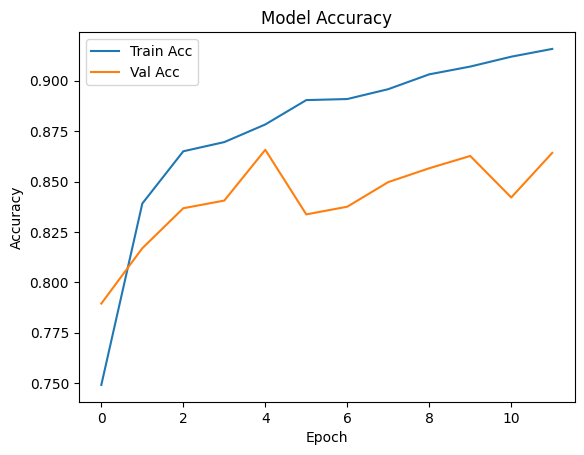

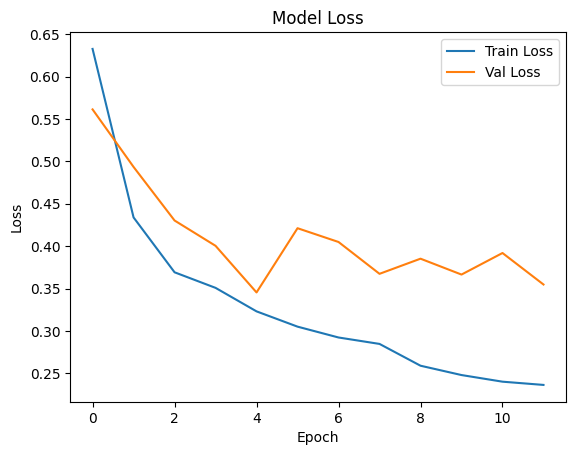

In [20]:
import matplotlib.pyplot as plt
import numpy as np
# Evaluate the model
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [22]:
# Save model to single file
  # or .keras

# Later, load it back
model.save('Brain_tumor_mobilenetV2.keras')



In [23]:
from tensorflow.keras.models import load_model
model = load_model('Brain_tumor_mobilenetV2.keras')

c:\Users\Saikat Mondal\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 6 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [30]:
# Reverse the class_indices mapping
class_labels = {v: k for k, v in train_generator.class_indices.items()}

def predict_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    prediction = model.predict(img_array)

    predicted_class_idx = np.argmax(prediction, axis=1)[0]
    predicted_class_label = class_labels[predicted_class_idx]

    print("Predicted class probabilities:", prediction)
    print("Predicted class index:", predicted_class_idx)
    print("Predicted class label:", predicted_class_label)
# Example usage
predict_image('BrainTumor/Testing/pituitary/Te-pi_0096.jpg')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Predicted class probabilities: [[0.0190715  0.07798087 0.00109237 0.9018553 ]]
Predicted class index: 3
Predicted class label: pituitary


In [31]:
import pickle 
with open('training_Mobile_netv2.pkl', 'wb') as file:
    pickle.dump(history.history, file)